# Twitter NLP & Sentiment Analysis

 1. Define the Project Scope
Goal: Classify tweets as positive, negative, or neutral (or binary sentiment).

Data Source: Twitter API (X API), or a pre-downloaded dataset (e.g., Sentiment140).

Output: Trained ML model, evaluation report, and optional dashboard or API.



## Project Goal

- To build a sentiment classifier that accurately predicts whether a tweet is positive or negative, with strong recall and precision on both classes — especially valuable for tasks like brand monitoring, public opinion analysis, or political sentiment tracking.

## Load Dependencies

In [2]:
import os
import sys
import importlib
import tweepy
import time
from tweepy import Paginator

sys.path.append("../scripts")
import fetch_tweets_copy as xnlp

## Load tweets (X_API or Kaggle Datasets)

In [2]:
# Sentiment140 dataset with 1.6 million tweets from kaggle
df = xnlp.load_tweets()
df.head()


🔍 How would you like to load tweets?
1. Fetch from Twitter API
2. Load from Kaggle


Enter 1 or 2:  2



🔹 Available Datasets:

Dataset 1: kazanova/sentiment140 - Sentiment140 dataset with 1.6 million tweets
Files:
  - training.1600000.processed.noemoticon.csv (Size: 238803811 bytes)

Dataset 2: krishbaisoya/tweets-sentiment-analysis - Sentiment140
Files:
  - Exploring Data.ipynb (Size: 43137 bytes)
  - test_data.csv (Size: 26885 bytes)
  - train_data.csv (Size: 102946957 bytes)
  - vocab.json (Size: 1183439 bytes)
  - vocab.py (Size: 1110 bytes)



Enter the number of the dataset you want to use:  1


⚠️  Failed to read with utf-8 encoding, trying next...
✅ Successfully read with latin1 encoding

✅ Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY            

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


## Preprocess Dataframe

### 1. Rename Columns

In [4]:
df.columns = ["sentiment", "id", "created_at", "query", "user", "text"]
df.head()

,sentiment,id,created_at,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   sentiment   1599999 non-null  int64 
 1   id          1599999 non-null  int64 
 2   created_at  1599999 non-null  object
 3   query       1599999 non-null  object
 4   user        1599999 non-null  object
 5   text        1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### 2: Clean structure & Visualise

In [5]:
# drop irrelevant columns and encode sentiment label if available
tweets_df= df.copy()
tweets_df = xnlp.drop_and_encode_sentiment(tweets_df)
print(tweets_df.info())
tweets_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581465 entries, 0 to 1581464
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   sentiment    1581465 non-null  object        
 1   created_at   1581465 non-null  datetime64[ns]
 2   text         1581465 non-null  object        
 3   month        1581465 non-null  object        
 4   day_of_week  1581465 non-null  object        
 5   season       1581465 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 72.4+ MB
None


,sentiment,created_at,text,month,day_of_week,season
0,negative,2009-04-06 22:19:49,is upset that he can't update his Facebook by ...,April,Monday,Spring
1,negative,2009-04-06 22:19:53,@Kenichan I dived many times for the ball. Man...,April,Monday,Spring
2,negative,2009-04-06 22:19:57,my whole body feels itchy and like its on fire,April,Monday,Spring
3,negative,2009-04-06 22:19:57,"@nationwideclass no, it's not behaving at all....",April,Monday,Spring
4,negative,2009-04-06 22:20:00,@Kwesidei not the whole crew,April,Monday,Spring


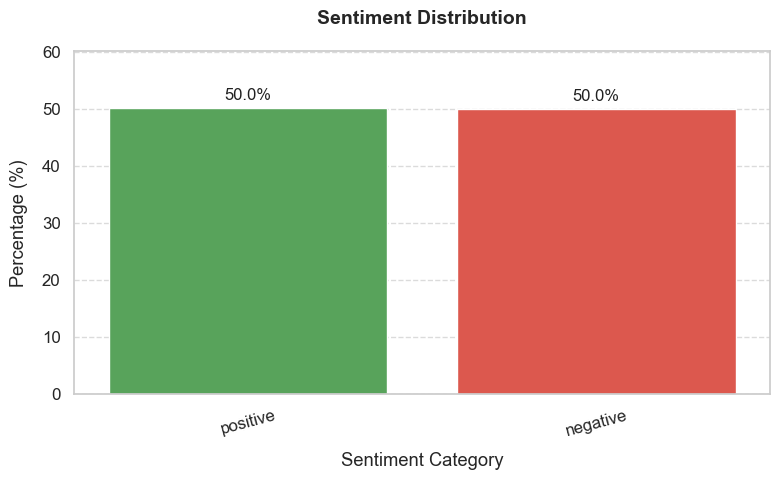

In [6]:
# Plotting sentiment distribution to check imbalance .# Works with various column names like 'Sentiment', 'label', etc.
xnlp.plot_sentiment_distribution(tweets_df, title="Sentiment Distribution")

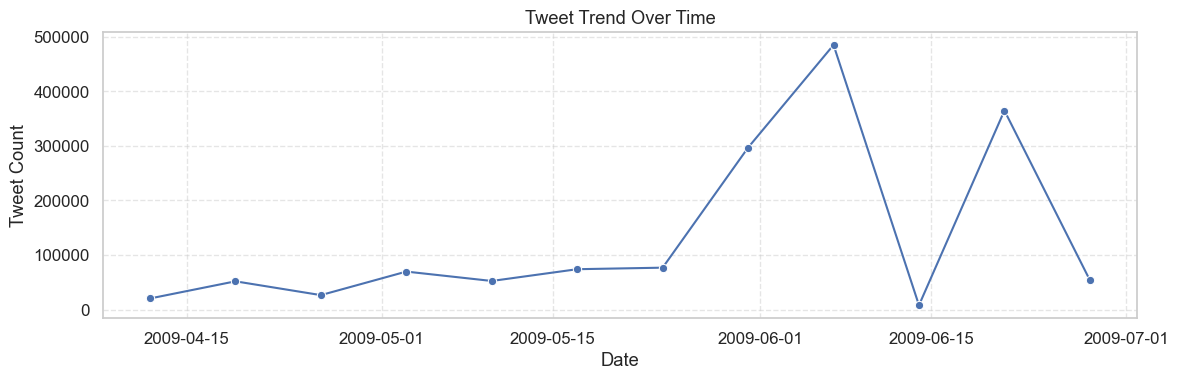

In [7]:
# Plotting tweet trend over time
xnlp.plot_time_trend(tweets_df)

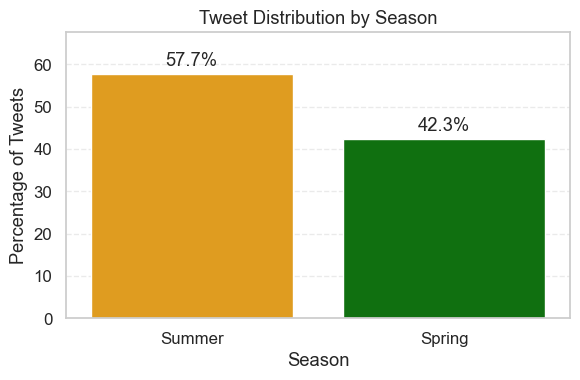

In [8]:
# Plot tweet distribution by season
xnlp.plot_seasonal_trend(tweets_df)

### 3: Clean tweet text

In [9]:
# remove_urls, remove_mentions @mentions, remove_hashtags (bool): Remove hashtags (but keep words if False)
# remove non-alphabetic characters, convert text to lowercase
tweets_df["clean_text"] = tweets_df["text"].apply(xnlp.clean_text)
tweets_df.head()

,sentiment,created_at,text,month,day_of_week,season,clean_text
0,negative,2009-04-06 22:19:49,is upset that he can't update his Facebook by ...,April,Monday,Spring,is upset that he cant update his facebook by t...
1,negative,2009-04-06 22:19:53,@Kenichan I dived many times for the ball. Man...,April,Monday,Spring,i dived many times for the ball managed to sav...
2,negative,2009-04-06 22:19:57,my whole body feels itchy and like its on fire,April,Monday,Spring,my whole body feels itchy and like its on fire
3,negative,2009-04-06 22:19:57,"@nationwideclass no, it's not behaving at all....",April,Monday,Spring,no its not behaving at all im mad why am i her...
4,negative,2009-04-06 22:20:00,@Kwesidei not the whole crew,April,Monday,Spring,not the whole crew


In [10]:
selected_columns = ["sentiment", "created_at", "clean_text"]
tweets_subset = tweets_df[selected_columns].copy()  
tweets_subset.head()

,sentiment,created_at,clean_text
0,negative,2009-04-06 22:19:49,is upset that he cant update his facebook by t...
1,negative,2009-04-06 22:19:53,i dived many times for the ball managed to sav...
2,negative,2009-04-06 22:19:57,my whole body feels itchy and like its on fire
3,negative,2009-04-06 22:19:57,no its not behaving at all im mad why am i her...
4,negative,2009-04-06 22:20:00,not the whole crew


### 4. Remove Stop Words and Irrelevant Words (standard stopwords list from sklearn)

In [11]:
tweets_subset = xnlp.remove_stopwords(
    tweets_subset,
    text_col="clean_text",
    new_col="filtered_text"  
)
tweets_subset.head()

,sentiment,created_at,clean_text,filtered_text
0,negative,2009-04-06 22:19:49,is upset that he cant update his facebook by t...,upset update texting result school today blah
1,negative,2009-04-06 22:19:53,i dived many times for the ball managed to sav...,dived times ball managed save rest bounds
2,negative,2009-04-06 22:19:57,my whole body feels itchy and like its on fire,body feels itchy
3,negative,2009-04-06 22:19:57,no its not behaving at all im mad why am i her...,behaving mad
4,negative,2009-04-06 22:20:00,not the whole crew,crew


### 5. Lemmatization (optional .only  if df is small)

In [19]:
tweets_subset["filtered_text"] = tweets_subset["filtered_text"].apply(xnlp.lemmatize_text)
tweets_subset.head()

,sentiment,created_at,text,month,day_of_week,season,clean_text
0,negative,2009-04-06 22:19:49,is upset that he can't update his Facebook by ...,April,Monday,Spring,upset update texting result school today blah
1,negative,2009-04-06 22:19:53,@Kenichan I dived many times for the ball. Man...,April,Monday,Spring,dived time ball managed save rest bound
2,negative,2009-04-06 22:19:57,my whole body feels itchy and like its on fire,April,Monday,Spring,body feel itchy like
3,negative,2009-04-06 22:19:57,"@nationwideclass no, it's not behaving at all....",April,Monday,Spring,behaving im mad
4,negative,2009-04-06 22:20:00,@Kwesidei not the whole crew,April,Monday,Spring,crew


## Pre-Model Visualizations

#### Word Frequency (Unigrams)


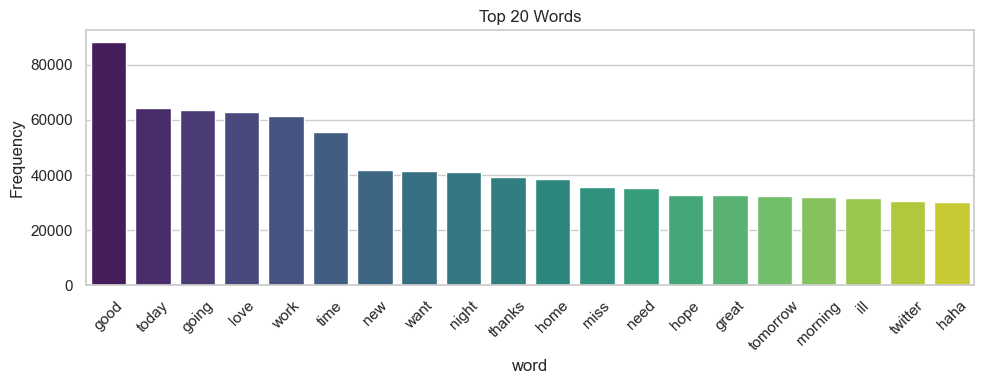

In [59]:
# Top words (Vocabulary insight)
xnlp.plot_top_words(tweets_subset, text_col="filtered_text", top_n=20)

#### Bigram / Trigram Analysis

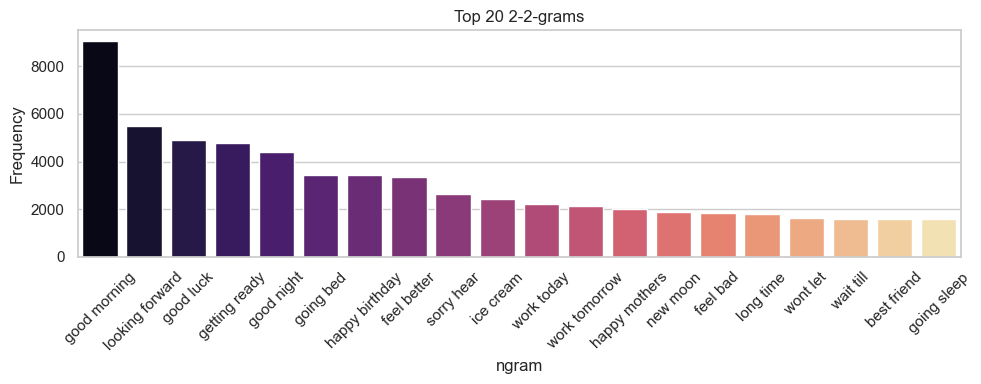

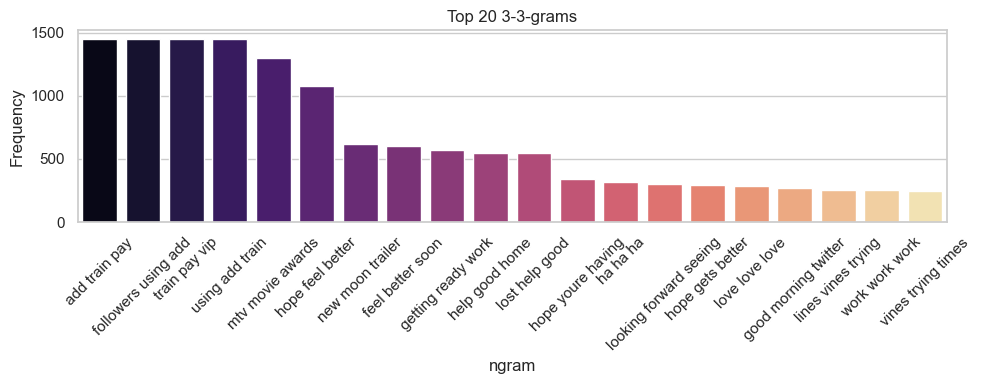

In [60]:
# N-grams: Phrases & context clues
xnlp.plot_ngrams(tweets_subset, text_col="filtered_text", ngram_range=(2, 2), top_n=20)  # bigrams
xnlp.plot_ngrams(tweets_subset, text_col="filtered_text", ngram_range=(3, 3), top_n=20)  # trigrams

#### Word Clouds (Per Sentiment)

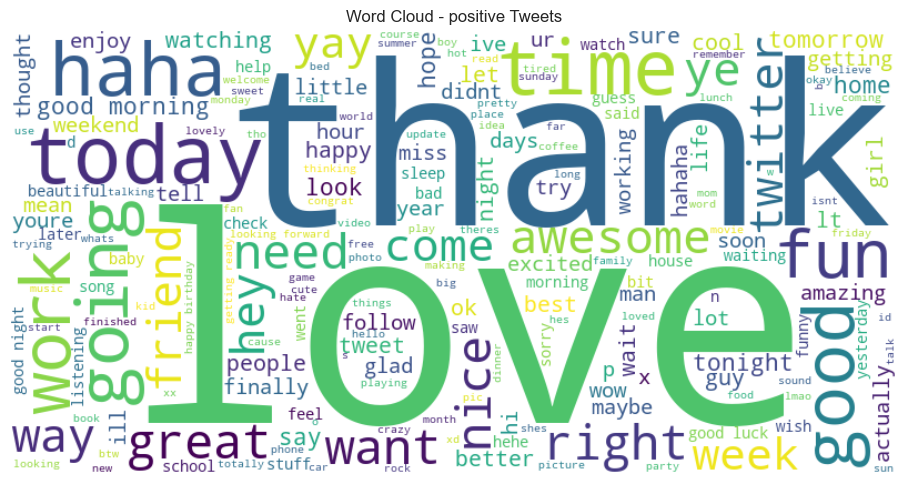

In [63]:
# text distribution (by sentiment)
xnlp.plot_wordcloud(tweets_subset, text_col="filtered_text", sentiment="positive")

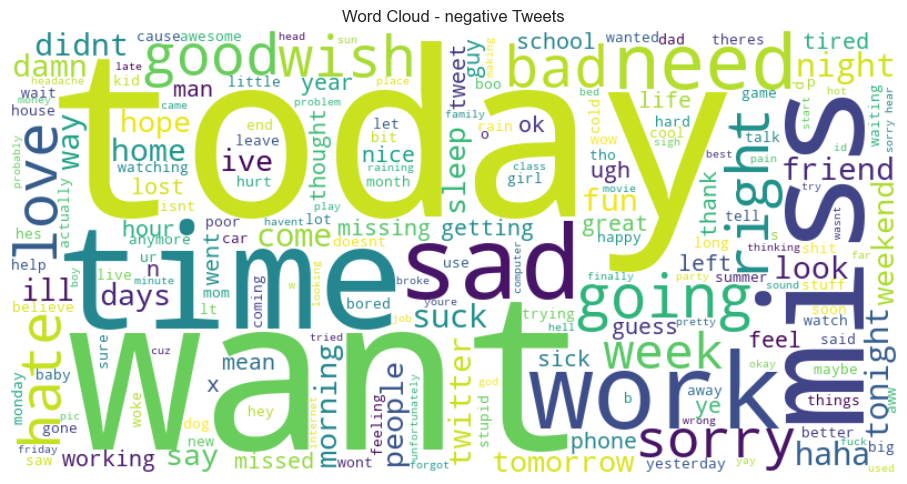

In [64]:
xnlp.plot_wordcloud(tweets_subset, text_col="filtered_text", sentiment="negative")

## Train a Sentiment Classifier

- Since our dataset is not skewed, i.e. it has equal number of Positive and Negative Predictions. We're choosing Accuracy as our evaluation metric.
- run_training_pipeline() Trains 3 models, Selects the best based on accuracy, Saves model and vectorizer (.pkl), Returns the best model, vectorizer, and a dictionary of results
> - LogisticRegression
> - "NaiveBaye
> -   "LinearSVM


...Splitting data...

...Vectorizing text with TF-IDF...

...Training and evaluating models...

LogisticRegression Accuracy: 0.7605
              precision    recall  f1-score   support

    negative       0.78      0.73      0.75    158037
    positive       0.75      0.79      0.77    158256

    accuracy                           0.76    316293
   macro avg       0.76      0.76      0.76    316293
weighted avg       0.76      0.76      0.76    316293



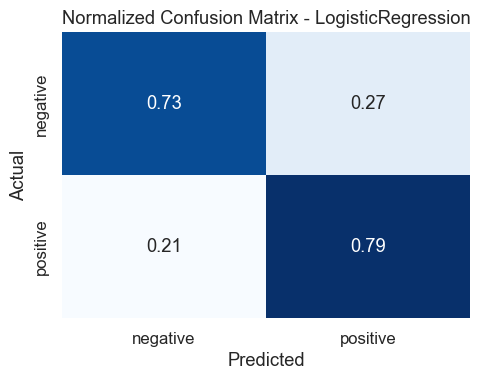


NaiveBayes Accuracy: 0.7505
              precision    recall  f1-score   support

    negative       0.76      0.73      0.75    158037
    positive       0.74      0.77      0.75    158256

    accuracy                           0.75    316293
   macro avg       0.75      0.75      0.75    316293
weighted avg       0.75      0.75      0.75    316293



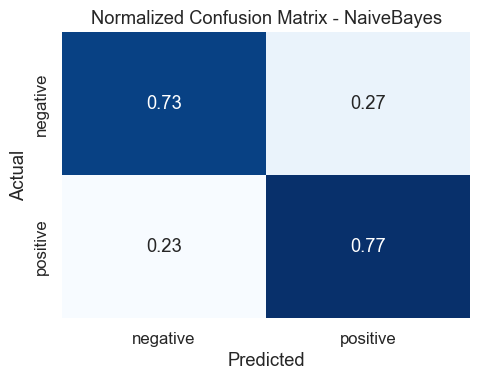


LinearSVC Accuracy: 0.7596
              precision    recall  f1-score   support

    negative       0.78      0.72      0.75    158037
    positive       0.74      0.80      0.77    158256

    accuracy                           0.76    316293
   macro avg       0.76      0.76      0.76    316293
weighted avg       0.76      0.76      0.76    316293



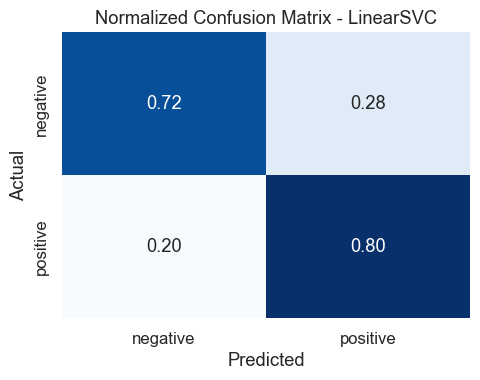

In [30]:
# Train,evaluate and select best model 
best_model, vectorizer, results = xnlp.run_training_pipeline(
    df=tweets_subset,
    text_col="filtered_text",         
    label_col="sentiment",           
    max_features=5000               
)

### visualize result & Plot Model Comparison

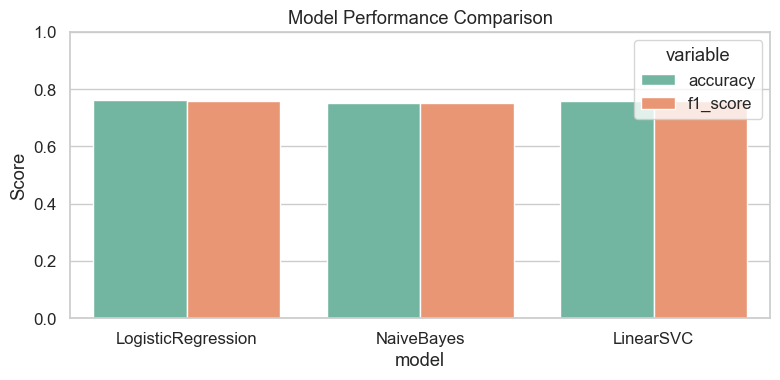

In [15]:
# plot 
xnlp.plot_model_performance(results)

In [31]:
# Display result
print(f"\n Best model '{best_model.name}'  with accuracy: {best_model.score:.4f}")
results


 Best model 'LogisticRegression'  with accuracy: 0.7605


,model,accuracy,f1_score,precision_pos,recall_pos,precision_neg,recall_neg
0,LogisticRegression,0.760494,0.760258,0.745436,0.791673,0.777569,0.729272
1,NaiveBayes,0.750519,0.750447,0.742629,0.767307,0.758964,0.733708
2,LinearSVC,0.759609,0.759301,0.742606,0.795161,0.779231,0.724008


** Key Insights:**
- Logistic Regression is the best-performing model based on both accuracy (76.05%) and F1-score (76.03%).
> - It also offers the highest recall for positive tweets (0.7917), which is crucial if the aim is to identify as many supportive tweets as possible.
> - Its negative class recall (0.7293) is also higher than SVC’s, making it more balanced.

- LinearSVC is a strong runner-up with slightly better precision but lower recall on the negative class — it may be preferred in applications where false positives are more costly.

- Naive Bayes, while simplest and fastest, trails behind in all metrics and is best suited for basic or interpretability-focused use cases.

***Logistic Regression is the most reliable and balanced model for this tweet sentiment classification task. It generalizes well across both positive and negative tweets, making it well-suited for production deployment or further tuning.***

In [38]:
# Save model and vectorizer
print("\n...Saving best model and vectorizer based on accuracy...")
xnlp.save_best_model(best_model, vectorizer)


...Saving best model and vectorizer based on accuracy...

✅ [2025-04-06 23:33:57] Best model 'LogisticRegression' saved with accuracy: 0.7605


## Make Prediction on new data

In [ ]:
# get tweets from twitterAPI
import recent_search as rs
importlib.reload(rs)
# Usage example
if __name__ == "__main__":
    try:
        df = xnlp.fetch_tweet(
            search_query="#Arsenal",
            max_results=100,
            max_retries=5,
            base_wait=30
        )
        print(f"Successfully fetched {len(df)} tweets")
    except Exception as e:
        print(f"Failed to fetch tweets: {str(e)}")
        

Rate limited. Waiting 30 seconds (retry 1/5)
Rate limited. Waiting 60 seconds (retry 2/5)
Rate limited. Waiting 120 seconds (retry 3/5)
Rate limited. Waiting 240 seconds (retry 4/5)
Rate limited. Waiting 480 seconds (retry 5/5)
Rate limited. Waiting 960 seconds (retry 6/5)


In [1]:
df.head()

NameError: name 'df' is not defined

In [7]:
importlib.reload(xnlp)

<module 'fetch_tweets_copy' from 'D:\\portfolio\\my_projects\\DataAnalysis\\notebooks\\../scripts\\fetch_tweets_copy.py'>